## DATA IMPORTING

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
from azureml.opendatasets import UsPopulationZip

population = UsPopulationZip()
population_df = population.to_pandas_dataframe()

In [38]:
df1 = pd.read_csv('train.csv').dropna() #Training Dataset
df2 = pd.read_csv('test.csv') #Testing dataset
codf = pd.read_csv('US_COVID_data_state_level.csv') #Covid data of cities
cidf = pd.read_csv('city_details.csv') #Cities data
wadf = pd.read_csv('warehouse_mapping.csv') #Warehouse data

In [39]:
df1['date']=pd.to_datetime(df1.date)
df1.sort_values('date',inplace = True)
df1.index = np.arange(df1.shape[0])
codf['date']=pd.to_datetime(codf.date)
codf.sort_values('date',inplace = True)
codf.index = np.arange(codf.shape[0])

## Predicting Confirmed Cases

In [40]:
corl = codf[codf.conf_cases.notna()] #Non-empty cells of confirmed cases

In [41]:
a,b = list(corl.tot_cases),list(corl.conf_cases)

In [42]:
from sklearn.ensemble import RandomForestRegressor 
algo=RandomForestRegressor()
ratio = []
for i in range(len(a)):
    if b[i]!=0:
        ratio.append((a[i]-b[i])/(b[i]))
    else:
        ratio.append(0)
a=np.array(a).reshape(-1,1)
algo.fit(a,ratio)

RandomForestRegressor()

In [43]:
for i in codf[codf.conf_cases.isna()].index:
    codf.iloc[i,3] = int(np.array(codf.iloc[i,2])/(1+algo.predict(np.array(codf.iloc[i,2].reshape(1,-1)))))

In [44]:
codf.sample(5)

,date,state,tot_cases,conf_cases
21856,2021-01-27,WY,51368,43826.0
27887,2021-08-02,MD,365529,314009.0
4509,2020-03-28,AL,2554,2420.0
13929,2020-09-07,VI,153,152.0
10354,2020-07-07,OR,10605,10605.0


## DATA CLEANING

In [88]:
cidf1 = cidf.drop(['country'],axis = 1) #dropping useless columns
cidf1 = cidf1.drop_duplicates()
cidf1.tail(),cidf1.shape

(            city  zip_code state  state_name
 554  WESTMINSTER     92683    CA  CALIFORNIA
 555      ONTARIO     91761    CA  CALIFORNIA
 556       TACOMA     98409    WA  WASHINGTON
 557      BOZEMAN     59718    MT     MONTANA
 558    CLACKAMAS     97015    OR      OREGON,
 (555, 4))

In [89]:
value,counts = np.unique(cidf1.zip_code,return_counts=True)
value[counts>1],counts[counts>1]

(array([94080, 98027], dtype=int64), array([2, 2], dtype=int64))

In [90]:
cidf1[cidf1.zip_code == 94080]

,city,zip_code,state,state_name
370,S,94080,CA,CALIFORNIA
371,EL,94080,CA,CALIFORNIA


In [91]:
cidf1.drop(index=371,inplace=True)

In [92]:
cidf1[cidf1.zip_code == 98027]

,city,zip_code,state,state_name
69,ISSAQUAH,98027,WA,WASHINGTON
70,US,98027,WA,WASHINGTON


In [93]:
cidf1.drop(index=70,inplace=True)

In [94]:
uszips = pd.read_csv('uszips.csv')
# zips = uszips.zip.unique()
# sum =0
# for z in y:
#     if z in zips:
#         sum+=1
#     else: print(z)
# sum,y.shape
cidf1 = cidf1.merge(uszips[['zip','population']],how='left',right_on='zip',left_on='zip_code')

In [102]:
state = cidf1.state.unique()
num_cities = [cidf1[cidf1.state == st].zip_code.nunique() for st in state]
stct = pd.DataFrame({'state':state,'num_cities':num_cities})
cidf1['city_weight'] = cidf1['population']/cidf1['population'].sum()

## DATA PREPROCESSING

In [103]:
cidf_final = cidf1.merge(stct,on = 'state',how = 'left')

In [104]:
cidf_final

,city,zip_code,state,state_name,zip,population,city_weight,num_cities
0,SEATTLE,98134,WA,WASHINGTON,98134,779.0,0.000037,32
1,ANCHORAGE,99515,AK,ALASKA,99515,22226.0,0.001055,4
2,COLUMBIA,21075,MD,MARYLAND,21075,34939.0,0.001658,11
3,TUSTIN,92782,CA,CALIFORNIA,92782,23166.0,0.001099,126
4,ANTIOCH,94509,CA,CALIFORNIA,94509,69295.0,0.003288,126
...,...,...,...,...,...,...,...,...
548,WESTMINSTER,92683,CA,CALIFORNIA,92683,90833.0,0.004310,126
549,ONTARIO,91761,CA,CALIFORNIA,91761,60827.0,0.002886,126
550,TACOMA,98409,WA,WASHINGTON,98409,27918.0,0.001325,32
551,BOZEMAN,59718,MT,MONTANA,59718,39282.0,0.001864,5


In [105]:
wadf.sample(5)

,wh_id,warehouse_name,city
528,770,WAREHOUSE 770 SOUTH OGDEN,SOUTH
551,9,WAREHOUSE 9 ALOHA,ALOHA
236,183,WAREHOUSE 183 ALTAMONTE SPRINGS,ALTAMONTE
167,1267,WAREHOUSE 1267 GREAT OAKS,GREAT
126,1194,WAREHOUSE 1194 PERRYSBURG,PERRYSBURG


In [113]:
m = codf.merge(cidf_final,how = 'left',on='state') 
print(m.shape)
m['avg_tot_cases/num_cities'] = m['tot_cases']/m['num_cities']
m['avg_conf_cases/num_cities'] = m['conf_cases']/m['num_cities']
m['avg_tot_cases/city_weight'] = m['tot_cases']*m['city_weight']
m['avg_conf_cases/city_weight'] = m['conf_cases']*m['city_weight']
m.sample(5) #merging covid data and cities data using state as a common entity

(276208, 12)


,date,state,tot_cases,conf_cases,month,city,zip_code,state_name,zip,population,city_weight,num_cities,avg_tot_cases/num_cities,avg_conf_cases/num_cities,avg_tot_cases/city_weight,avg_conf_cases/city_weight
66080,2020-05-10,CA,853674,770708.0,5,REDDING,96003.0,CALIFORNIA,96003.0,44171.0,0.002096,126.0,6775.190476,6116.730159,1789.145627,1615.263962
197926,2021-01-05,CA,3649956,3649956.0,1,LAGUNA,92677.0,CALIFORNIA,92677.0,65508.0,0.003108,126.0,28967.904762,28967.904762,11344.839986,11344.839986
38278,2020-03-20,CO,363,299.0,3,WESTMINSTER,80031.0,COLORADO,80031.0,35753.0,0.001696,14.0,25.928571,21.357143,0.615794,0.507224
131423,2020-09-07,CA,398263,385752.0,9,NORTHRIDGE,91324.0,CALIFORNIA,91324.0,30995.0,0.001471,126.0,3160.817460,3061.523810,585.703753,567.304505
77781,2020-05-31,GA,45612,45583.0,5,WOODSTOCK,30188.0,GEORGIA,30188.0,63869.0,0.003030,14.0,3258.000000,3255.928571,138.224694,138.136811


In [114]:
b = []
for row in wadf.values:
  b.append(row[1].split()[2]) #taking 3rd word from warehouse_name which is city

wadf['city'] = np.array(b)
wadf.sample(5)

,wh_id,warehouse_name,city
86,1120,WAREHOUSE 1120 WASHINGTON DC,WASHINGTON
156,1236,WAREHOUSE 1236 FLEMINGTON,FLEMINGTON
129,1197,WAREHOUSE 1197 FLORENCE,FLORENCE
214,1375,WAREHOUSE 1375 SURPRISE,SURPRISE
354,386,WAREHOUSE 386 BRENTWOOD,BRENTWOOD


In [115]:
x = df1.merge(wadf.drop(axis = 1,columns=['warehouse_name']),how='left',on = 'wh_id')

In [116]:
print(x.shape)
x.sample(5)
# merged data of train and warehouse datasets

(449995, 4)


,date,wh_id,sales,city
350323,2020-09-19,1272.0,200,WOODBURY
427315,2021-02-22,29.0,77,ROSEVILLE
414748,2021-01-21,1197.0,47,FLORENCE
17974,2019-02-03,1232.0,8,COLUMBIA
249815,2020-03-23,1030.0,508,W


In [117]:
z = x.merge(m,how='left', on = ['date','city'])

In [118]:
print(z.shape)
z.sample(5)

(646135, 18)


,date,wh_id,sales,city,state,tot_cases,conf_cases,month,zip_code,state_name,zip,population,city_weight,num_cities,avg_tot_cases/num_cities,avg_conf_cases/num_cities,avg_tot_cases/city_weight,avg_conf_cases/city_weight
300188,2020-04-10,386.0,711,BRENTWOOD,TN,205255.0,196648.0,4.0,37027.0,TENNESSEE,37027.0,57096.0,0.002709,5.0,41051.000000,39329.600000,556.052547,532.735481
642526,2021-11-03,663.0,240,CONCORD,CA,3544840.0,3544840.0,11.0,94520.0,CALIFORNIA,94520.0,38709.0,0.001837,126.0,28133.650794,28133.650794,6510.659681,6510.659681
56669,2019-04-13,1161.0,20,FORT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
559016,2020-12-22,736.0,10,CHANDLER,AZ,467540.0,447422.0,12.0,85226.0,ARIZONA,85226.0,39614.0,0.001880,18.0,25974.444444,24856.777778,878.787509,840.973745
601145,2021-02-19,368.0,36,S,MO,545979.0,468779.0,2.0,63128.0,MISSOURI,63128.0,30480.0,0.001446,6.0,90996.500000,78129.833333,789.600304,677.952890


In [120]:
#precovid data
precov = z[z.state.isna()][['date','wh_id','sales','tot_cases','conf_cases','avg_tot_cases/num_cities','avg_conf_cases/num_cities',
                            'avg_tot_cases/city_weight','avg_conf_cases/city_weight']].fillna(0)
cov = z[z.state.notna()][['date','wh_id','sales','tot_cases','conf_cases','avg_tot_cases/num_cities','avg_conf_cases/num_cities',
                            'avg_tot_cases/city_weight','avg_conf_cases/city_weight']]
precov.sort_values(['date','wh_id'],ignore_index=True,inplace = True)
cov.sort_values(['date','wh_id'],ignore_index=True,inplace = True)

## EDA

In [121]:
# Import libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Configuring styles
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (25, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [122]:
def week_avg_wh_id(wh_id):
    week_avg = []
    start = 0
    shape = df1[df1.wh_id == wh_id].shape[0]
    while start<shape:
        week_avg.append(df1[df1.wh_id == wh_id][start:start+7].sales.mean())
        start += 7
    return week_avg

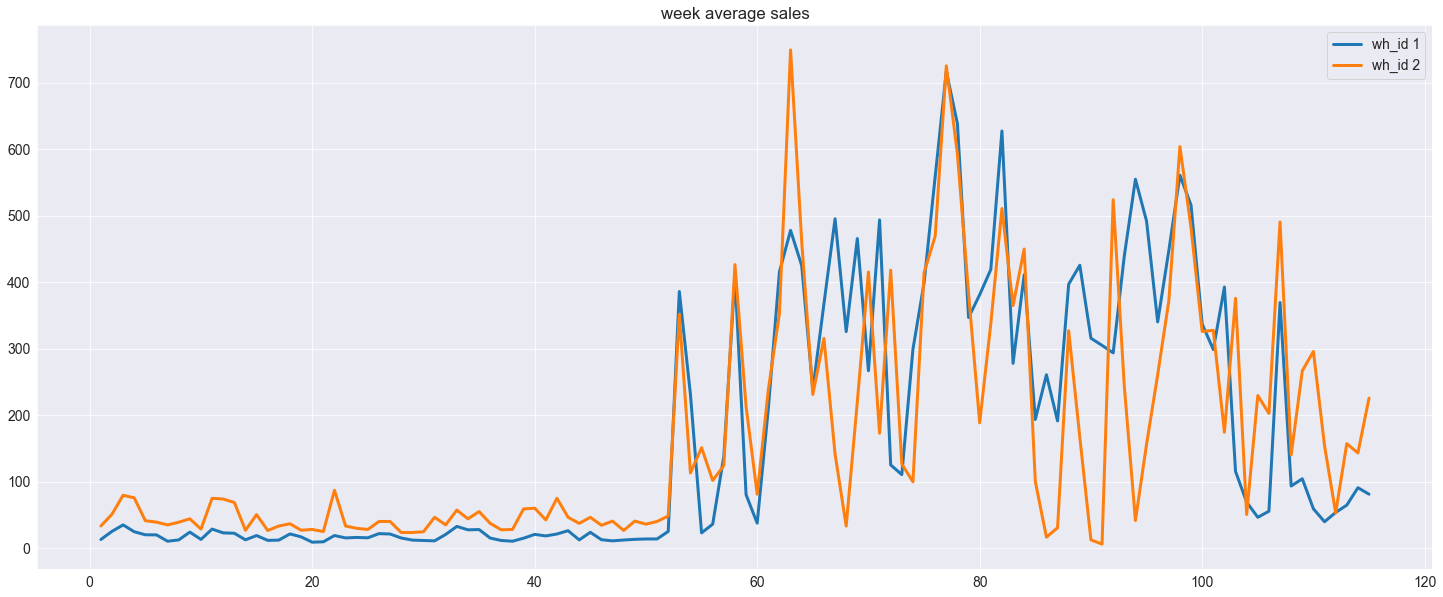

In [123]:
legend = []
for i in range(1,3):
    y = week_avg_wh_id(df1.wh_id.unique()[i])
    plt.plot(range(1,len(y)+1),y,linewidth = 3)
    legend.append('wh_id ' + str(i))
plt.legend(legend);
plt.title('week average sales');

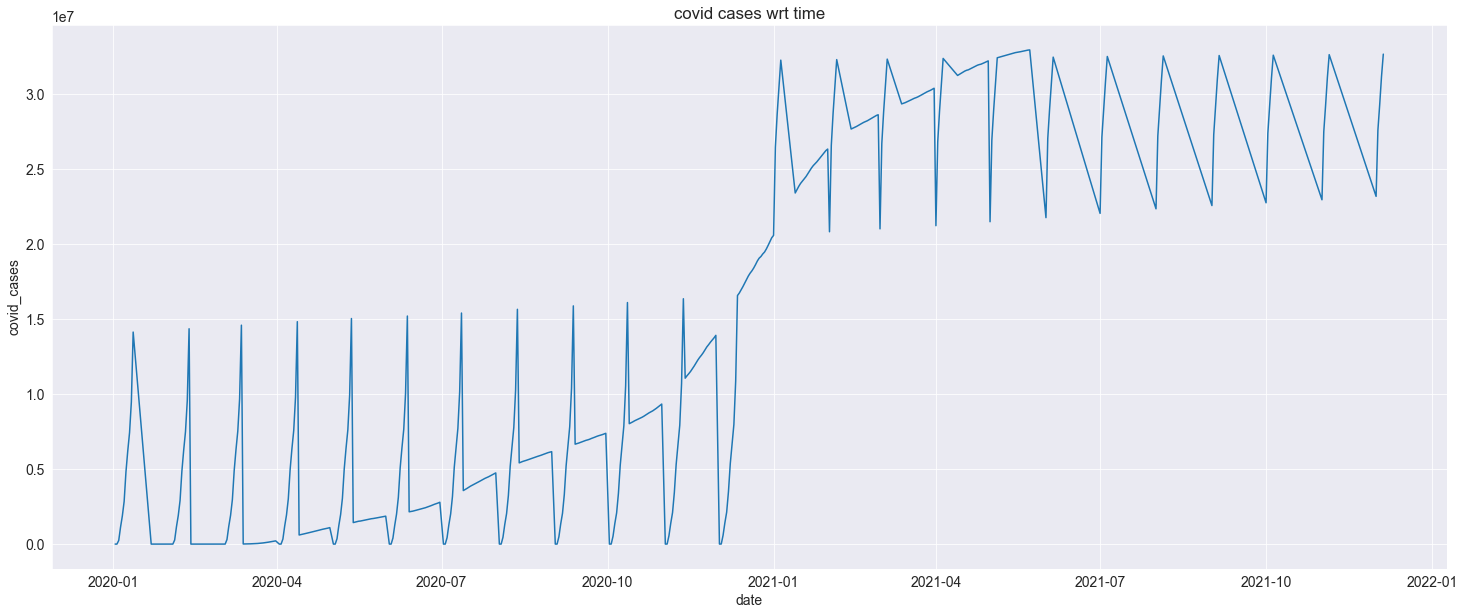

In [124]:
plt.plot(codf.date.unique(),codf.groupby('date').sum().tot_cases)
plt.title('covid cases wrt time')
plt.xlabel('date')
plt.ylabel('covid_cases');

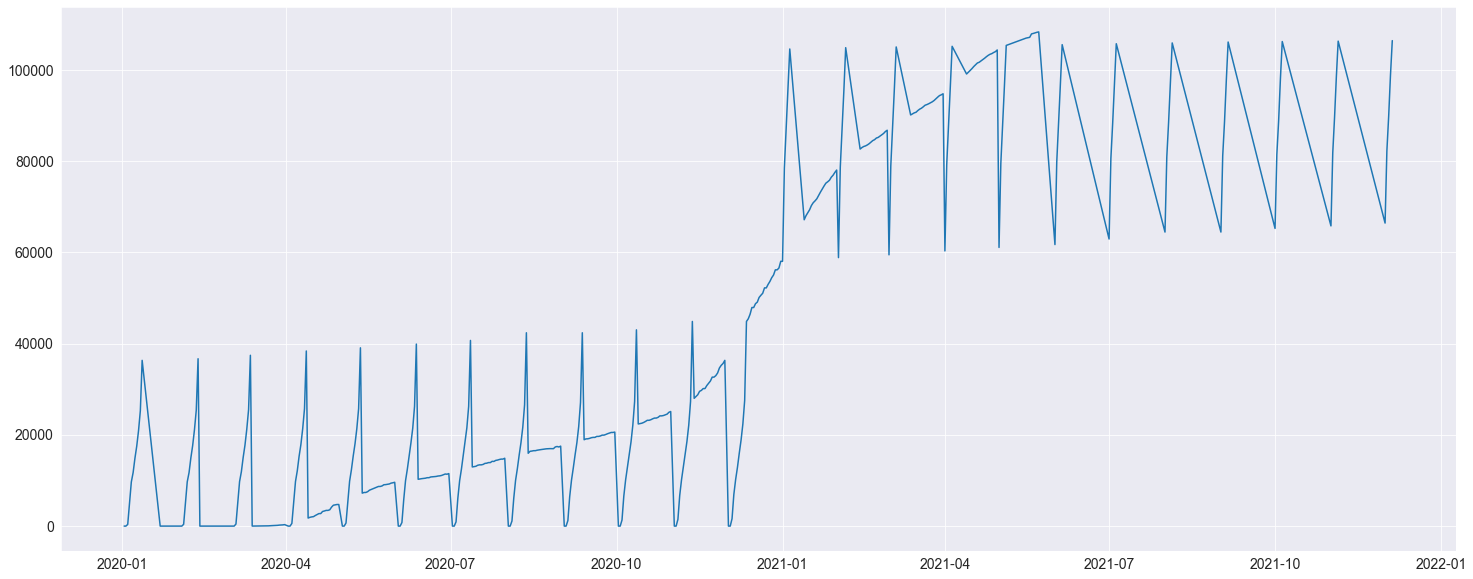

In [125]:
def cov_cases_state(state):
    plt.plot(codf[codf.state==state].date,codf[codf.state==state].tot_cases)
    
cov_cases_state('DE')

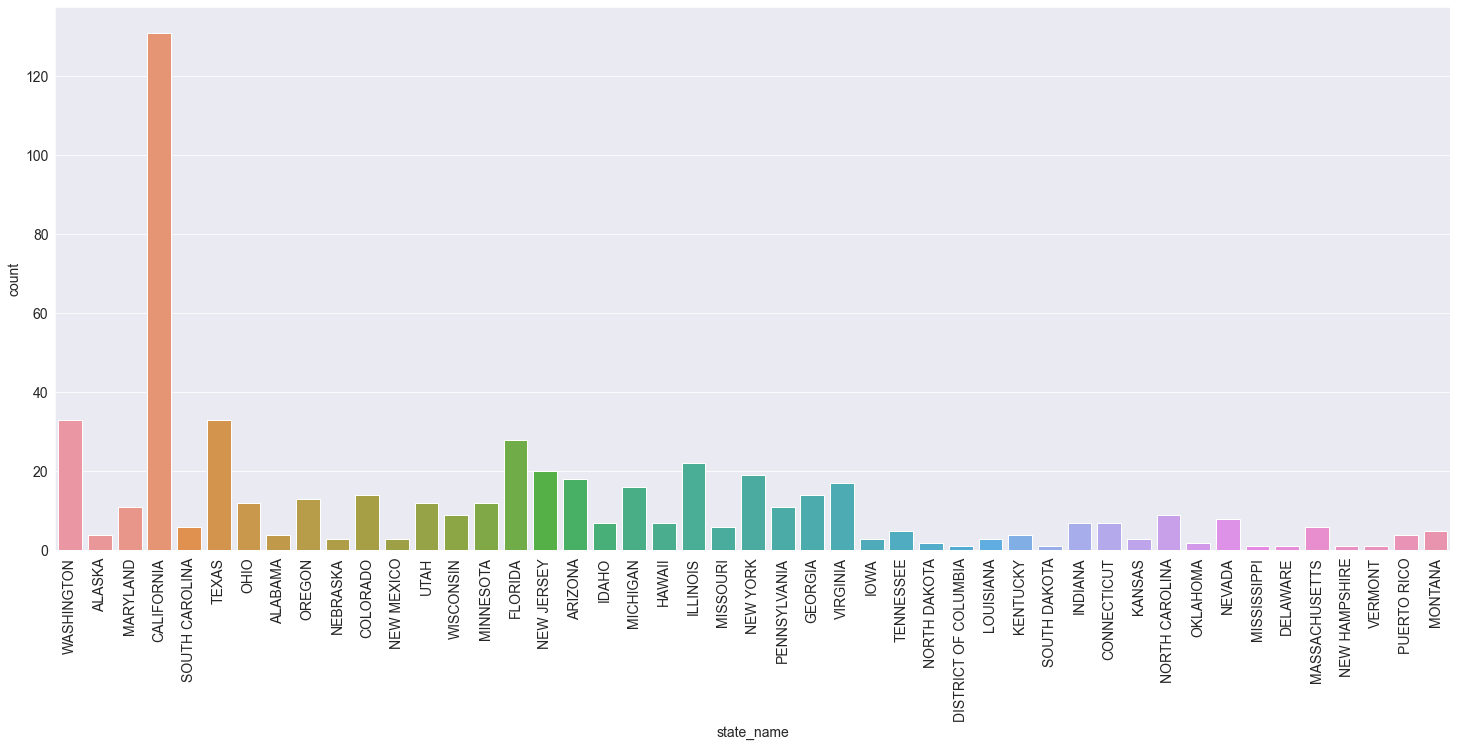

In [126]:
# State vs No.of cities
fig=sns.countplot(x=cidf.state_name);
plt.xticks(rotation=90);
plt.show();

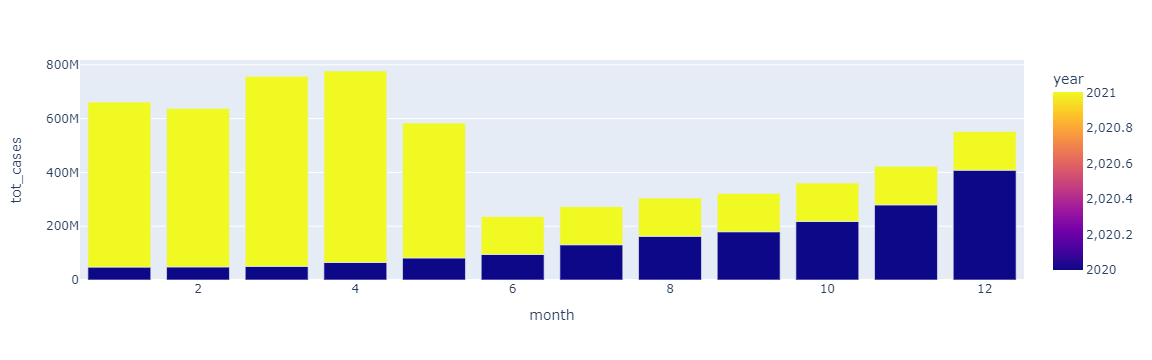

In [127]:
codf['month'] = codf.date.dt.month
cov_eda_2020 = codf[codf.date.dt.year == 2020].groupby('month').sum()
cov_eda_2020['year'],cov_eda_2020['month'] = 2020,cov_eda_2020.index
cov_eda_2021 = codf[codf.date.dt.year == 2021].groupby('month').sum()
cov_eda_2021['year'],cov_eda_2021['month'] =2021,cov_eda_2021.index
cov_eda = pd.concat([cov_eda_2020,cov_eda_2021])
px.bar(cov_eda,x='month',y='tot_cases',color = 'year')

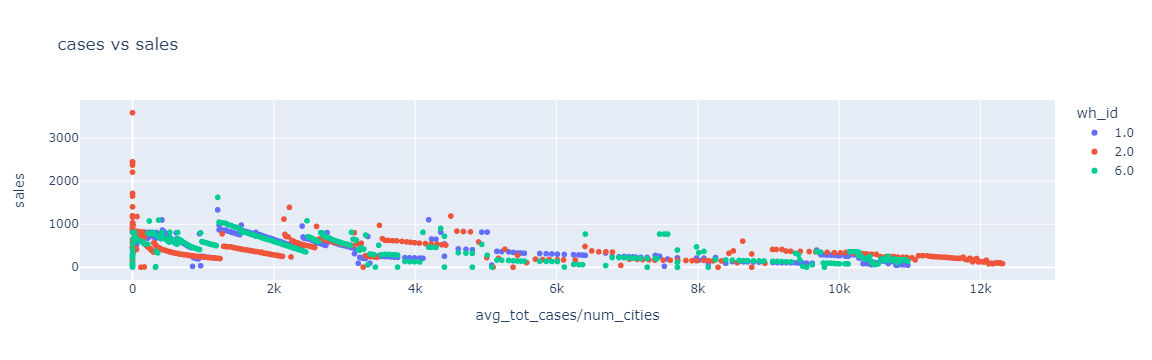

In [130]:
cov['wh_id']=cov['wh_id'].astype('object')
fig = px.scatter(cov[(cov.wh_id==1)|(cov.wh_id==2)|(cov.wh_id==6)], x="avg_tot_cases/num_cities", y="sales",
                 title='cases vs sales',color='wh_id')
fig.show()

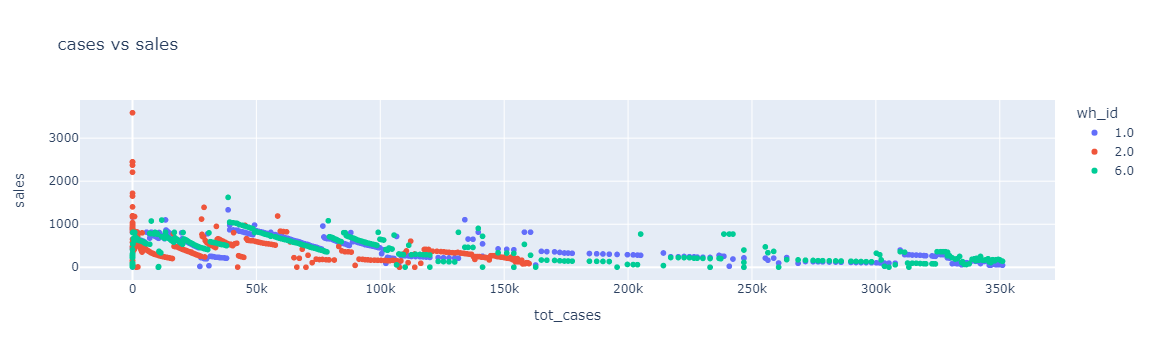

In [131]:
cov['wh_id']=cov['wh_id'].astype('object')
fig = px.scatter(cov[(cov.wh_id==1)|(cov.wh_id==2)|(cov.wh_id==6)], x="tot_cases", y="sales",
                 title='cases vs sales',color='wh_id')
fig.show()

## Training

In [132]:
z[(z.date == pd.to_datetime('12/03/2021')) & (z.city == 'COLUMBIA')]

,date,wh_id,sales,city,state,tot_cases,conf_cases,month,zip_code,state_name,zip,population,city_weight,num_cities,avg_tot_cases/num_cities,avg_conf_cases/num_cities,avg_tot_cases/city_weight,avg_conf_cases/city_weight
645746,2021-12-03,1232.0,157,COLUMBIA,SC,537779.0,456553.0,12.0,29210.0,SOUTH CAROLINA,29210.0,40488.0,0.001921,6.0,89629.833333,76092.166667,1033.110008,877.069342
645747,2021-12-03,1232.0,157,COLUMBIA,MD,392581.0,370401.0,12.0,21075.0,MARYLAND,21075.0,34939.0,0.001658,11.0,35689.181818,33672.818182,650.812900,614.043342
645949,2021-12-03,1000.0,12,COLUMBIA,SC,537779.0,456553.0,12.0,29210.0,SOUTH CAROLINA,29210.0,40488.0,0.001921,6.0,89629.833333,76092.166667,1033.110008,877.069342
645950,2021-12-03,1000.0,12,COLUMBIA,MD,392581.0,370401.0,12.0,21075.0,MARYLAND,21075.0,34939.0,0.001658,11.0,35689.181818,33672.818182,650.812900,614.043342


In [133]:
values,counts = np.unique(cidf_final.city,return_counts=True)

In [134]:
values[counts>1],counts[counts>1]

(array(['AURORA', 'AVON', 'BURBANK', 'COLUMBIA', 'COMMERCE', 'CYPRESS',
        'DALLAS', 'E', 'EAST', 'EL', 'EVERETT', 'FORT', 'GRAND', 'HAYWARD',
        'LA', 'LAKE', 'LANCASTER', 'LINCOLN', 'LYNNWOOD', 'MIAMI', 'MT',
        'N', 'NE', 'NEW', 'NORTH', 'NORWALK', 'NW', 'PALM', 'RANCHO',
        'ROCHESTER', 'ROSEVILLE', 'S', 'SACRAMENTO', 'SAN', 'SANTA', 'SE',
        'SOUTH', 'ST', 'SW', 'UNION', 'W', 'WEST', 'WESTMINSTER',
        'WOODLAND'], dtype=object),
 array([ 2,  2,  2,  2,  2,  2,  3,  7,  3,  2,  2,  4,  2,  2,  4,  3,  2,
         2,  2,  2,  4,  6,  4,  4,  3,  2,  4,  2,  3,  2,  2,  5,  2, 10,
         5,  4,  2,  5,  4,  2,  8,  4,  2,  2], dtype=int64))

### DATA SPLITTING

In [135]:
import torch
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.utils.data as utils
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torch.nn as nn

In [ ]:
# target_sensor = "Austin"
# features = list(df.columns.difference([target_sensor]))

# forecast_lead = 15
# target = f"{target_sensor}_lead{forecast_lead}"

# df[target] = df[target_sensor].shift(-forecast_lead)
# df = df.iloc[:-forecast_lead]